In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ZeroMean
from gpytorch.kernels import  MaternKernel

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 20,
})

In [3]:
# Create the Gaussian Process model following the example: https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

class MyGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, mean_function, kernel):
        super(MyGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean_function
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_GPR(x_train, y_train,kernel, mean_function, likelihood, epochs):
    l=[]

    model = MyGPModel(x_train, y_train, likelihood, mean_function, kernel)

    # Training the model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Use Adam optimizer

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training loop
    for i in range(epochs):

        optimizer.zero_grad()
        output = model(x_train)
        loss = -mll(output, y_train)
        l+= [loss.item()]

        loss.backward()
        optimizer.step()

        print('\n******* Iteration {} *******'.format(i+1))

        for param_name, param in model.named_parameters():
            print(f'Parameter name: {param_name:42} value = {param.item()}')

        print(f'Epoch {i+1}/{epochs}, Loss: {loss.item()}')
        
    return model, l

def make_predictions(model, x_train, likelihood):
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(float(min(x_train).item()-5), float(max(x_train).item()+5), 100)
        observed_pred = likelihood(model(test_x))
        var = observed_pred.variance
        # lower, upper = observed_pred.confidence_region()
        return test_x, observed_pred, var, var

def plot_predictions(x_train, y_train,test_x, observed_pred, lower, upper):
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), observed_pred.mean.numpy()-1.96*np.sqrt(lower.numpy()), observed_pred.mean.numpy()+1.96*np.sqrt(upper.numpy()), alpha=0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [4]:
X = torch.tensor([-4.3, -4.6, -4.8, -3.1, -1.4, -5.6, -6.8, -4.1, -0.5, -2.4, -4.9, -3.6, -8.2, -5.9, -4.0,
                  -8.5, -8.6, -0.6, -7.0, -7.4, -2.6, -2.9, -9.7, -2.2, -8.1, -1.9, -5.3, -6.7, -8.0, -0.4,
                  -3.5, -5.8, -2.3, -1.5, -9.8, 10.0, 10.2, 10.1, 10.6, 9.5, -6.8, -7.0, -6.8, -6.9, -6.8],
                 dtype=torch.float64).reshape((-1, 1))

Y = torch.tensor([-0.6, 0.0, 0.2, -1.8, -1.7, 1.3, 1.8, -0.6, -0.6, -2.2, 0.3, -1.2, 1.5, 1.5, -1.1, 1.1, 1.4,
                  -0.7, 2.1, 1.8, -1.8, -1.9, -0.1, -2.1, 1.6, -1.9, 0.5, 1.5, 1.3, -0.7, -1.3, 1.6, -2.2, -1.6,
                  -0.3, 0.7, 1.1, 0.9, 1.0, 0.6, 2.0, 1.9, 1.9, 2.1, 1.9],
                 dtype=torch.float64).reshape((-1, 1)).squeeze(-1)

X_t = torch.linspace(float(min(X).item()-5), float(max(X).item()+5), 100, dtype=torch.float64).unsqueeze(-1)


******* Iteration 1 *******
Parameter name: likelihood.noise_covar.raw_noise           value = -0.09999998658895493
Parameter name: covar_module.raw_lengthscale               value = 0.09999998658895493
Epoch 1/200, Loss: 1.1539543498206752

******* Iteration 2 *******
Parameter name: likelihood.noise_covar.raw_noise           value = -0.20006227493286133
Parameter name: covar_module.raw_lengthscale               value = 0.19991907477378845
Epoch 2/200, Loss: 1.1179249719354991

******* Iteration 3 *******
Parameter name: likelihood.noise_covar.raw_noise           value = -0.3002226948738098
Parameter name: covar_module.raw_lengthscale               value = 0.29968804121017456
Epoch 3/200, Loss: 1.0815727440142568

******* Iteration 4 *******
Parameter name: likelihood.noise_covar.raw_noise           value = -0.4005124270915985
Parameter name: covar_module.raw_lengthscale               value = 0.3992275595664978
Epoch 4/200, Loss: 1.0449579547370649

******* Iteration 5 *******
Parame

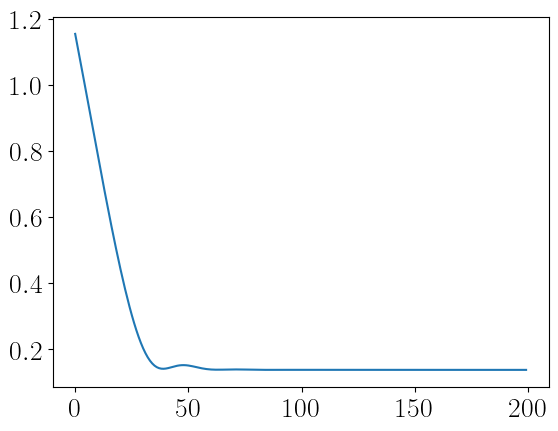

In [5]:
likelihood = GaussianLikelihood()
mean_function = ZeroMean()
kernel = MaternKernel(nu=1.5)

num_iter = 200

model, l = train_GPR(X,Y,kernel, mean_function, likelihood, num_iter)

plt.plot(l)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x, observed_pred, lower, upper = make_predictions(model, X, likelihood)

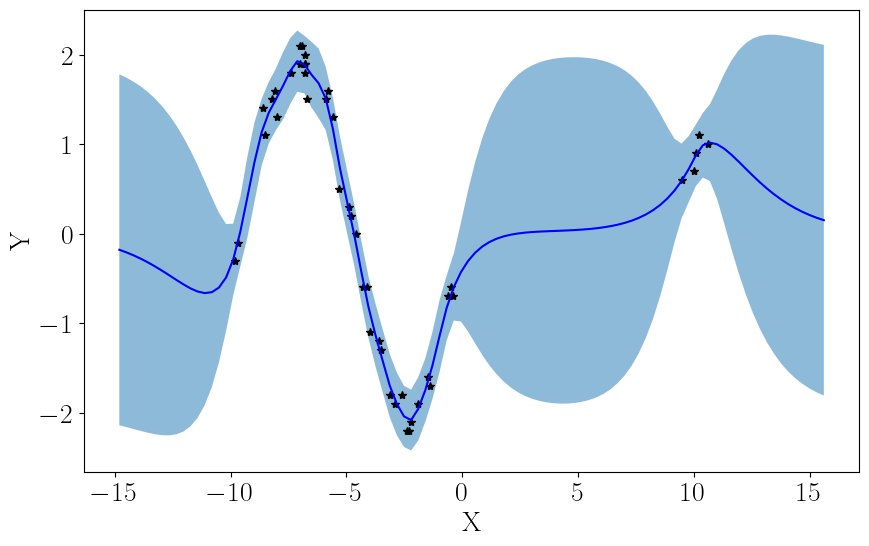

Kernel parameters: lenghtscale = Parameter containing:
tensor([[2.4240]], requires_grad=True), noise_var= Parameter containing:
tensor([-3.7276], requires_grad=True), exp_noise_var= tensor([0.0241], grad_fn=<ExpBackward0>)


In [6]:
plot_predictions(X,Y,test_x, observed_pred, lower, upper)
# get model parameters and print them
print(f"Kernel parameters: lenghtscale = {model.covar_module.raw_lengthscale}, noise_var= {model.likelihood.noise_covar.raw_noise}, exp_noise_var= {torch.exp(model.likelihood.noise_covar.raw_noise)}")

In [7]:
library_mu = observed_pred.mean.numpy()

In [8]:
manual_mu = np.load("manual_mu.npy")

In [9]:
library_mu-manual_mu

array([-1.47836403e-05, -1.58647000e-05, -1.68379774e-05, -1.76409364e-05,
       -1.81990050e-05, -1.84260902e-05, -1.82266489e-05, -1.75001709e-05,
       -1.61492844e-05, -1.40931771e-05, -1.12886769e-05, -7.76221260e-06,
       -3.65705755e-06,  6.98171771e-07,  4.69168904e-06,  7.29052812e-06,
        6.84780756e-06,  1.75077105e-06, -4.65540322e-06, -9.19142727e-06,
       -8.74052363e-06, -2.59330329e-06,  4.47734957e-06,  6.84808742e-06,
        1.06051562e-06, -5.47629641e-06,  4.23945970e-07,  8.44922935e-06,
        2.43284528e-06, -5.78328634e-06, -2.65629508e-06,  7.54834068e-06,
        2.57516453e-06, -3.87488606e-06, -1.07150948e-06,  2.11854704e-06,
       -4.91150701e-07, -2.92068199e-06, -1.48223964e-07, -1.27640478e-06,
       -2.52195598e-08,  4.14366526e-06,  1.19752259e-06,  1.05520124e-06,
        2.11368754e-06, -9.36519767e-07, -3.21873776e-06,  4.14691524e-07,
        5.12458313e-06,  8.56246032e-06,  1.04468618e-05,  1.20950287e-05,
        1.30273912e-05,  